<h1><center>Modelagem em Série Temporal</center></h1>

**Nome do Projeto:** Comparativo entre modelos estatístico e de regressão para previsão de quantidade de acidentes semanais para o estado de São Paulo

**Autor:** Alex Takishita

**Data:** 14/12/2023

---

## Introdução

Neste projeto, será realizada a modelagem do conjunto de dados de acidentes registrados pela Polícia Rodoviária Federal, através do modelo estatístico ARIMA, e dos modelos de regressão Linear e XGBoost. O objetivo será prever a quantidade de acidentes esperados para semanas futuras, ao passo em que será comparado os resultados entre os modelos usados.

---

## Conjunto de Dados

O conjunto de dados é disponibilizado pela Polícia Rodoviária Federal (PRF) e fornece uma visão abrangente de acidentes de trânsito ocorridos em rodovias por todo o território brasileiro, registrando a localização, indivíduos envolvidos, condições de pista e metereológica, etc.  
No momento da obteção dos dados para este projeto, o conjunto disponibilizado possuía registros de ocorrências até o mês de setembro de 2023 e, para este projeto, foi limitado aos anos de 2021 à 2023.  

Os dados e os metadados podem ser obtidos através de:  

**Dados:** https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf  
**Dicionário dos dados:** https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dicionario-dados-acidentes-2016  

---

## Estrutura do Notebook

- **1.** Pré-processamento de Dados  
- **2.** Modelos  
    - **2.1.** ARIMA  
        - **2.1.1.** Teste de Estacionaridade  
        - **2.1.2.** Autocorrelação
        - **2.1.3.** Modelagem  
        - **2.1.4.** Forecasting  
	- **2.2.** Regressão  
        - **2.2.1.** Preparação dos dados  
        - **2.2.2.** Modelagem  
        - **2.2.3.** Forecasting  
    - **2.3.** Comparação  
    - **2.4.** Modelagem para perspectiva diária  
		- **2.4.1.** Preparação dos dados  
		- **2.4.2.** Modelagem  
            - **2.4.2.1.** Regressão Linear  
			- **2.4.2.2.** XGBoost  
- **3.** Conclusões  
- **4.** Referências

---

# 1. Pré-processamento de Dados

A primeira etapa deste projeto consiste em importar as bibliotecas e os dados que serão utilizados. Para manusear os dados serão utilizadas as bibliotecas **Pandas** e **Numpy** para manipulação e **Matplotlib** para visualização. Também será importada a função *filterwarnings* da biblioteca **Warnings** para eliminar avisos nas saídas das células.  

Como os dados são disponibilizados por ano, será utilizada a biblioteca **os** para ler o caminho onde estão os arquivos .csv e empilhá-los em um único Dataframe.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from warnings import filterwarnings as fw
import os


fw("ignore")

# caminho contendo os arquivos
file_path = r''

# Lista para armazenar os DataFrames lidos de cada arquivo
dfs = []

# Iterar sobre os arquivos na pasta
for file in os.listdir(file_path):
    if file.endswith('.csv'):
        path = os.path.join(file_path, file)
        df = pd.read_csv(path, sep=';', encoding='ANSI')
        dfs.append(df)

# Empilha os DataFrames em um único DataFrame
df = pd.concat(dfs, ignore_index=True)

# Visualização prévia dos dados
df.head(10)

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,331730.0,738258.0,2021-01-01,sexta-feira,05:30:00,SP,116.0,453,REGISTRO,Reação tardia ou ineficiente do condutor,...,Masculino,0,1,0,0,"-24,56168114","-47,86752174",SPRF-SP,DEL05-SP,UOP01-DEL05-SP
1,331804.0,738412.0,2021-01-01,sexta-feira,08:05:00,AM,174.0,937,MANAUS,Reação tardia ou ineficiente do condutor,...,Masculino,1,0,0,0,"-2,508068","-60,036434",SPRF-AM,DEL01-AM,UOP01-DEL01-AM
2,331815.0,738692.0,2021-01-01,sexta-feira,10:10:00,CE,222.0,"128,5",ITAPAJE,Velocidade Incompatível,...,Feminino,0,1,0,0,"-3,707626","-39,623509",SPRF-CE,DEL04-CE,UOP03-DEL04-CE
3,331815.0,738689.0,2021-01-01,sexta-feira,10:10:00,CE,222.0,"128,5",ITAPAJE,Velocidade Incompatível,...,Masculino,0,1,0,0,"-3,707626","-39,623509",SPRF-CE,DEL04-CE,UOP03-DEL04-CE
4,331823.0,740272.0,2021-01-01,sexta-feira,12:30:00,RJ,493.0,18,MAGE,Ingestão de álcool e/ou substâncias psicoativa...,...,Masculino,1,0,0,0,"-22,6687122","-43,01862696",SPRF-RJ,DEL02-RJ,UOP04-DEL02-RJ
5,331843.0,738562.0,2021-01-01,sexta-feira,14:40:00,RJ,393.0,252,BARRA DO PIRAI,Condutor Dormindo,...,Masculino,1,0,0,0,"-22,43422023","-43,77561487",SPRF-RJ,DEL05-RJ,UOP02-DEL05-RJ
6,331844.0,739897.0,2021-01-01,sexta-feira,15:20:00,BA,101.0,"818,1",ITAMARAJU,Velocidade Incompatível,...,Masculino,0,1,0,0,"-17,16637837","-39,57859039",SPRF-BA,DEL09-BA,UOP02-DEL09-BA
7,331855.0,738445.0,2021-01-01,sexta-feira,15:45:00,PR,277.0,"51,3",SAO JOSE DOS PINHAIS,Pista Escorregadia,...,Masculino,1,0,0,0,"-25,59515989","-48,90700787",SPRF-PR,DEL01-PR,UOP05-DEL01-PR
8,331857.0,738555.0,2021-01-01,sexta-feira,15:30:00,GO,20.0,183,ALVORADA DO NORTE,Demais falhas mecânicas ou elétricas,...,Masculino,1,0,0,0,"-14,456929","-46,474163",SPRF-DF,DEL02-DF,UOP02-DEL02-DF
9,331864.0,738673.0,2021-01-01,sexta-feira,17:10:00,SC,470.0,"79,1",INDAIAL,Transitar na contramão,...,Feminino,0,1,0,0,"-26,951565","-49,306534",SPRF-SC,DEL04-SC,UOP01-DEL04-SC


## Análise de quantidade de acidentes para o estado de São Paulo

Para este projeto, será analisado a quantidade de acidentes para apenas o estado de São Paulo. Como o dataset armazena cada indivíduo envolvido na ocorrência em uma linha distinta, é necessário remover as linhas duplicadas para capturar apenas um único registro para cada ocorrência de acidente.

In [2]:
# Filtro por estado
df_filter = df[df.uf == 'SP']
df_filter = df_filter[['id','data_inversa']].drop_duplicates()

Em seguida, será abordada a quantidade de acidentes ocorridos em São Paulo a partir de três perspectivas: Diária, Mensal e Semanal.

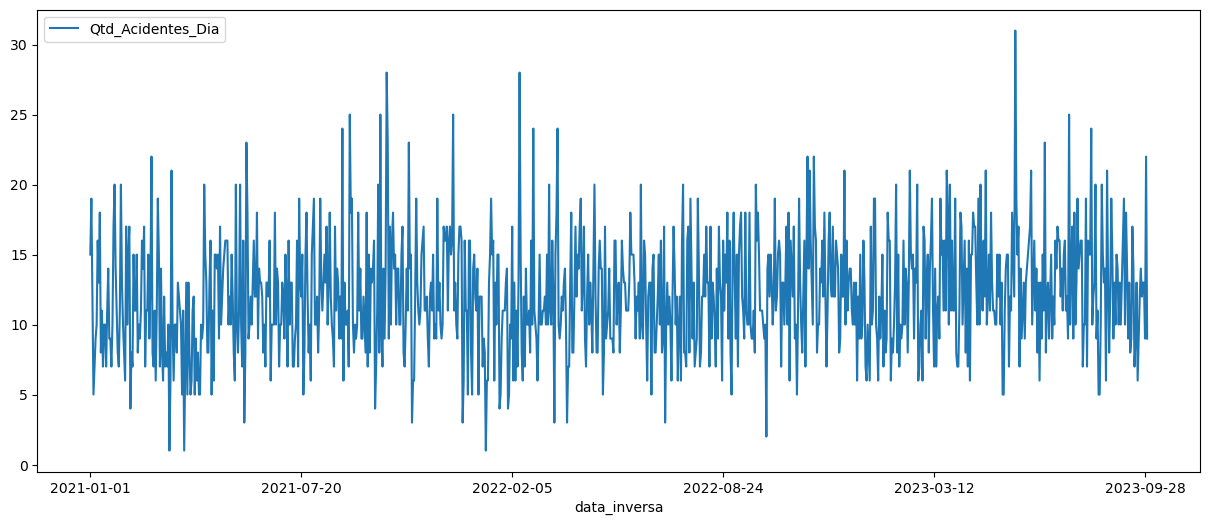

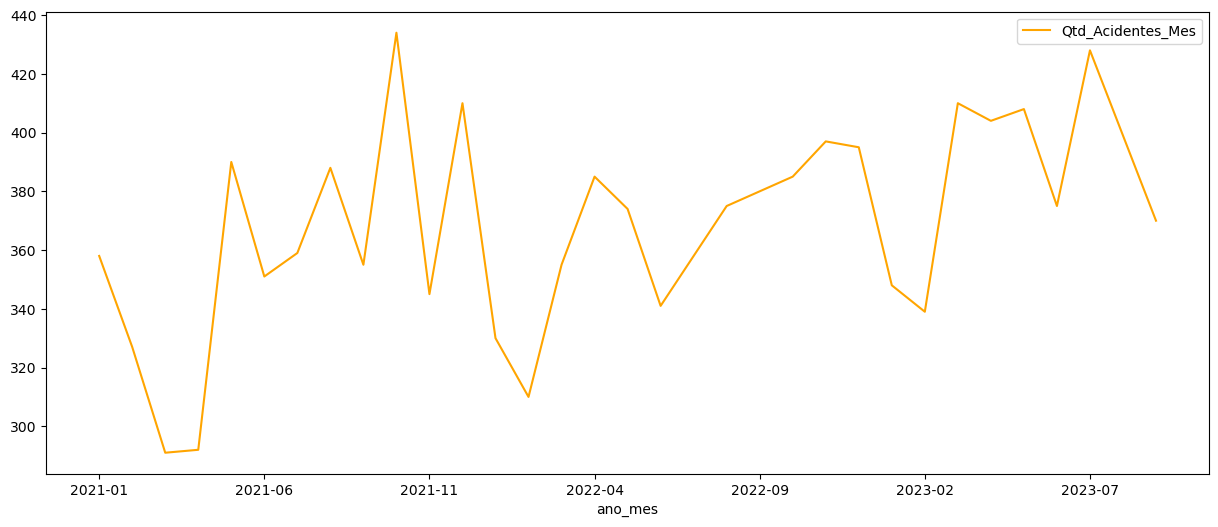

In [3]:
# Criando um dataframe cópia do dataframe filtrado
df_copy = df_filter.copy()

# Criando atributo ano-mês
df_copy['ano_mes'] = df_copy['data_inversa'].astype(str).str.slice(0, 7)

# Criando dois dataframes com agrupamentos por dia e por mês
df_dia = df_copy[['id','data_inversa']].groupby('data_inversa').count()
df_anomes = df_copy[['id','ano_mes']].groupby('ano_mes').count()
df_dia.rename(columns={'id': 'Qtd_Acidentes_Dia'}, inplace=True)
df_anomes.rename(columns={'id': 'Qtd_Acidentes_Mes'}, inplace=True)

# Visualização dos dataframes agrupados
df_dia.plot(figsize=(15, 6))
df_anomes.plot(figsize=(15,6), color='orange')
plt.show()

In [4]:
print("Quantidade de dias na base:", len(df_dia))
print("Quantidade de meses na base:", len(df_anomes))

Quantidade de dias na base: 1003
Quantidade de meses na base: 33


### Abordagem semanal

Para a abordagem semanal dos dados, será utilizada a técnica de resample, que aplica uma reamostragem nos dados temporais de modo a criar grupos de dados semanais. Após o agrupamento, será atribuído o valor médio da quantidade de acidentes ocorridos nas dadas semanas.

In [5]:
# Criando um dataframe cópia do dataframe filtrado
df_semanal = df_filter.copy()

# Definindo a data como índice para aplicar o resample
df_semanal['data_inversa'] = pd.to_datetime(df_semanal['data_inversa'])
df_semanal.set_index('data_inversa', inplace=True)

# Agrupando os acidentes por dia
df_semanal = df_semanal.groupby('data_inversa').count()

# O parâmetro 'W' agrupa por semana (Week)
df_semanal = df_semanal.resample('W').mean()
df_semanal = df_semanal.round(2)
df_semanal.rename(columns={'id': 'Qtd_Acidentes_Semana'}, inplace=True)

df_semanal.head()

,Qtd_Acidentes_Semana
data_inversa,
2021-01-03,15.33
2021-01-10,11.14
2021-01-17,9.14
2021-01-24,12.29
2021-01-31,12.00


Com o conjunto agrupado por semana, é possível verificar a quantidade de registros obtido e gerar o gráfico:

Quantidade de semanas na base: 144


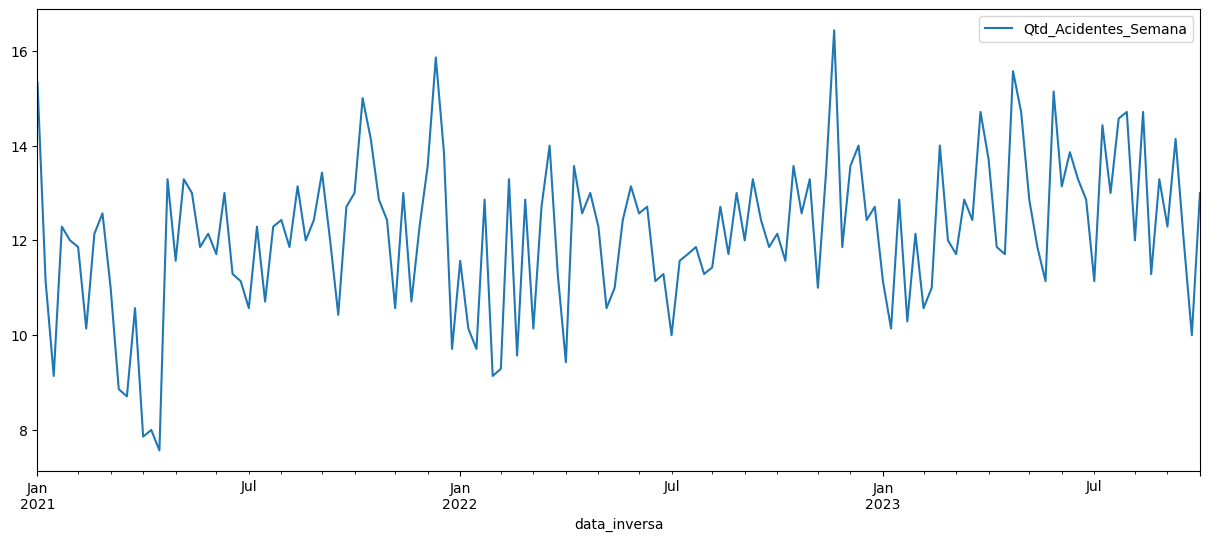

In [6]:
print("Quantidade de semanas na base:", len(df_semanal))

df_semanal.plot(figsize=(15,6))
plt.show()

Observando as quantidades de registros (dias, semanas e meses), a perspectiva de número de acidentes por mês não é uma boa abordagem para o projeto visto que se tem poucos dados (33). Por outro lado, a abordagem com número de ocorrências diárias possui mais dados, embora tenha maior variabilidade. Porém, afim de reproduzir os resultados visualmente, será abordada a perspectiva semanal em um primeiro momento, já que poderia ficar um pouco nebuloso a visualização comparativa entre a série e os valores preditos a partir da perspectiva diária.

Ademais, além da abordagem semanal ter apresentado uma melhor visualização da série temporal, outra vantagem é a redução de ruídos, já que os valores diários podem ser suscetíveis a flutuações de curto prazo. No entanto, a média semanal pode suavizar essas flutuações e fornecer uma visão mais clara das tendências de longo prazo.

# 2. Modelagem

---

Para prever a quantidade de acidentes em São Paulo para semanas futuras, iremos modelar através do modelo estatístico clássico **ARIMA** e através de modelos de **Regressão**.

---
## 2.1. ARIMA
---
### 2.1.1. Teste de Estacionaridade

Uma das condições necessárias para usar o modelo ARIMA é que a série temporal seja estacionária, isto é, que as propriedades estatísticas como média e variância sejam constantes em diferentes períodos de tempo.  
Visualmente, pode-se observar no gráfico gerado para quantidade de acidentes por semana, que a série parece manter constante a média e variância, dado que não há uma tendência "para cima" ou "para baixo", e sim uma distribuição entre altos e baixos. De mesmo modo ocorre para a série com quantidade diária de acidentes representada pelo primeiro gráfico, onde é mais fácil de notar uma possível estacionaridade.
  
Para verificar se a série é estacionária ou não, pode-se submeter o conjunto ao **Teste estatístico de estacionaridade ADF (Augmented Dickey-Fuller)**.   Para isso, será importada a função adfuller da biblioteca *statsmodels* e em seguida, aplicado o teste:

In [7]:
from statsmodels.tsa.stattools import adfuller

# Utilizando a métrica AIC
adf_test = adfuller(df_semanal, autolag = 'AIC')

# Resultados
print("1. ADF: %.2f" %adf_test[0])
print("2. p-value: ", adf_test[1])
print("3. Número de Lags: ", adf_test[2])
print("4. Número de Observações usadas para a Regressão ADF e Cálculo dos Valores Críticos: ", adf_test[3])
print("5. Valores Críticos: ")
for key, val in adf_test[4].items():
    print("\t",key, ": %.2f" %val)

1. ADF: -6.20
2. p-value:  5.771183172500553e-08
3. Número de Lags:  1
4. Número de Observações usadas para a Regressão ADF e Cálculo dos Valores Críticos:  142
5. Valores Críticos: 
	 1% : -3.48
	 5% : -2.88
	 10% : -2.58


O teste **ADF** é uma técnica estatística utilizada para determinar se uma série temporal possui raiz unitária, o que implica que a série é não-estacionária.

A métrica **ADF** é o resultado do teste estatístico propriamente dito. Em geral, quanto mais negativo for esse valor, mais forte é a evidência contra a presença de raiz unitária (ou seja, a favor da estacionariedade).  
Enquanto que **p-value** é a probabilidade de observar um valor da estatística do teste ADF tão extremo quanto o observado, assumindo que a série temporal possui raiz unitária (não é estacionária).  
Por fim, os **valores críticos** são limiares para comparar com a estatística do teste ADF para tomar decisões sobre a rejeição ou não da hipótese nula, a depender do nível de significância (1%, 5% e 10%).

Analisando os resultados obtidos, percebe-se que a estatística do teste ADF é bastante negativa, o valor p é muito baixo, e a estatística do teste está abaixo dos valores críticos em todos os níveis de significância. Isso sugere fortemente que se pode rejeitar a hipótese nula de raiz unitária e concluir que **a série temporal é estacionária** e pode ser usada, da forma como foi gerada, no modelo ARIMA sem ser necessário aplicar métodos de diferenciação.

---
### 2.1.2. Autocorrelação

Antes de aplicar o modelo estatístico ARIMA, serão gerados os gráficos **ACF (Autocorrelation Function)** e **PACF (Partial Autocorrelation Function)**. Estes gráficos permitem analisar a autocorrelação em uma série temporal e podem sugerir bons valores para os hiperparâmetros do modelo ARIMA.
  
Para a geração destes gráficos, serão utilizadas as funções *plot_acf* e *plot_pacf* da biblioteca *statsmodels*, com número de lags (atrasos) iguais à 25.

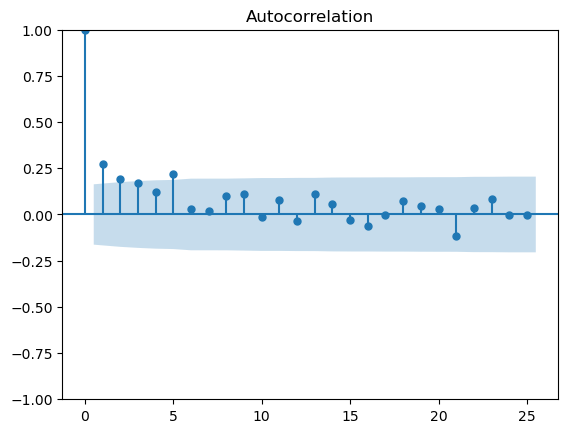

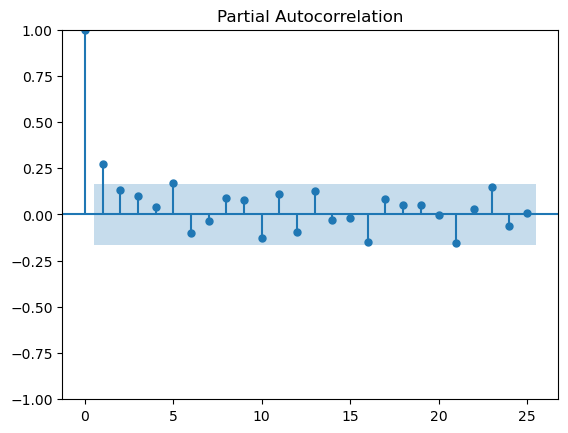

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_semanal, lags=25)
plot_pacf(df_semanal, lags=25)
plt.show()

O gráfico ACF exibe a autocorrelação entre uma série temporal e suas versões passadas (lags), proporcionando uma visão geral da correlação em diferentes pontos temporais. Por outro lado, o gráfico PACF mostra a autocorrelação parcial entre a série temporal e suas versões passadas, controlando explicitamente para a influência dos intervalos intermediários, o que destaca as relações diretas entre observações em diferentes momentos. A presença de uma imagem azul sólida ao fundo nos gráficos indica a inclusão de intervalos de confiança para as correlações calculadas, proporcionando uma medida da incerteza associada a essas estimativas. Esses intervalos ajudam a avaliar a significância estatística das correlações observadas nas análises de autocorrelação normal e parcial. 

Para o ACF, se a autocorrelação é significativamente diferente de zero em um determinado lag, isso sugere uma possível sazonalidade na série temporal, como por exemplo, um pico a cada 4 lags pode sugerir uma sazonalidade mensal em nossa perspectiva. Para o gráfico gerado não é perceptível um padrão de autocorrelação.  
  
Para o PACF, valores significativos indicam a correlação direta entre duas observações separadas por um número específico de intervalos de tempo. Um pico significativo no PACF no lag 1 sugere uma relação de autocorrelação direta com o valor imediatamente anterior.

#### Identificação dos hiperparâmetros p, d e q do ARIMA:

Para a modelagem do modelo ARIMA, são necessários três hiperparâmetros que compõem a ordem: p, d e q.  
  
**p (Ordem Autoregressiva):** Representa o número de lags (atrasos) que serão incluídos no modelo AR.  
**d (Ordem de Diferenciação):** Representa o número de diferenciações necessárias para tornar a série temporal estacionária.  
**q (Ordem de Média Móvel):** Representa o número de lags de erros (termos de média móvel) que serão incluídos no modelo MA.  
  
Analisando o gráfico ACF, há autocorrelações significativas até o lag 5, o que sugere que o valor de **q é 5**.
O mesmo cenário parece ocorrer no gráfico PACF, apesar de haver autocorrelações significativas em lags maiores. Logo, **p é 5**.  
O hiperparâmetro d não se aplica pois a série é estacionária, não necessitando de diferenciação. Portanto, **d é 0**.

---
### 2.1.3. Modelagem

**Separação entre conjunto de treinamento e de teste**

In [9]:
# Criando um dataframe cópia do dataframe filtrado
df_arima = df_semanal.copy()

# Proporção treino/teste igual a 85/15
t = int(np.round(len(df_arima)*0.15))

train = df_arima.iloc[:-t]
test  = df_arima.iloc[-t:]

print("Formato dataset original:",df_arima.shape)
print("Formato dos conjuntos de treino e teste:", train.shape,",", test.shape)

Formato dataset original: (144, 1)
Formato dos conjuntos de treino e teste: (122, 1) , (22, 1)


Será utilizado o modelo ARIMA disponível na biblioteca statsmodels com os hiperparâmetros obtidos na análise dos gráficos ACF e PACF, sobre o conjunto de treino:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Modelando e ajustando o arima com (p,d,q) = (5,0,5)
model_arima = ARIMA(train, order=(5,0,5))
modelfit = model_arima.fit()

In [11]:
modelfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Qtd_Acidentes_Semana   No. Observations:                  122
Model:                   ARIMA(5, 0, 5)   Log Likelihood                -218.349
Date:                  Sat, 13 Jan 2024   AIC                            460.698
Time:                          13:13:40   BIC                            494.346
Sample:                      01-03-2021   HQIC                           474.365
                           - 04-30-2023                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0035      0.262     45.747      0.000      11.489      12.518
ar.L1         -0.6067      0.660     -0.920      0.358      -1.900       0.686
ar.L2         -0.1861      0.310     -0.601      0.548      -0.793       0.421
ar.L3         -0.5785      0.243     -2.383      0.017      -1.054      -0.103
ar.L4          0.3134      0.324      0.968      0.333      -0.321       0.948
ar.L5          0.5295      0.499      1.061      0.289      -0.448       1.507
ma.L1          0.9018      0.677      1.332      0.183      -0.425       2.229
ma.L2          0.5201      0.355      1.466      0.143      -0.175       1.215
ma.L3          0.8975      0.362      2.479      0.013       0.188       1.607
ma.L4          0.0428      0.491      0.087      0.931      -0.920       1.006
ma.L5         -0.3245      0.482     -0.674      0.501      -1.269       0.620
sigma2         2.0639      0.364      5.666      0.000       1.350       2.778
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.72   Prob(JB):                         0.76
Heteroskedasticity (H):               0.70   Skew:                             0.07
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A função *summary* retorna resultados obtidos no modelo e que podem ser utilizados na comparação entre diferentes modelagens (diferentes ordens), como as métricas Log Likelihood, AIC, BIC e HQIC.  
  
Analisando a métrica AIC, que leva em consideração a qualidade do ajuste e a complexidade do modelo (e que quanto menor, melhor), pode-se dizer que se obteve um primeiro valor relativamente bom. Além das métricas estatísticas, pode-se realizar a predição e gerar o gráfico para comparar os resultados visualmente.

---
**Predição sobre o conjunto de teste**

In [12]:
start = len(train)
end   = len(train)+len(test)-1
pred  = modelfit.predict(start=start, 
                         end=end,
                         typ='levels')

pred.index = df_arima.index[start:end+1]
print(pred)

data_inversa
2023-05-07    12.527534
2023-05-14    12.381314
2023-05-21    12.304126
2023-05-28    13.182483
2023-06-04    12.289123
2023-06-11    11.832806
2023-06-18    11.666154
2023-06-25    12.603364
2023-07-02    12.514832
2023-07-09    11.874514
2023-07-16    11.443469
2023-07-23    12.080826
2023-07-30    12.613256
2023-08-06    12.173426
2023-08-13    11.498370
2023-08-20    11.653283
2023-08-27    12.443682
2023-09-03    12.469896
2023-09-10    11.772854
2023-09-17    11.424758
2023-09-24    12.080225
2023-10-01    12.577273
Freq: W-SUN, Name: predicted_mean, dtype: float64


Para estimar o erro, será criada uma função *'metricas'* que será utilizada para calcular as métricas:  

**Mean Absolute Error (MAE):** Média das diferenças absolutas entre os valores previstos e os valores reais.  
**Mean Absolute Error (MAPE):** Expressa percentualmente a métrica MAE.  
**Mean Squared Error (MSE):**  Média das diferenças quadráticas entre os valores previstos e os valores reais.  
**Root Mean Squared Error (RMSE):** Raiz quadrada da média dos erros quadráticos.

Para criar a função serão utilizadas as funções **mean_squared_error, mean_absolute_error** da biblioteca sklearn:

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def metricas(real,predito):
    mae  = np.round(mean_absolute_error(real, predito), decimals=2)
    mape = np.round(mean_absolute_percentage_error(real,predito)*100, decimals=2)
    mse  = np.round(mean_squared_error(real, predito), decimals=2)
    rmse = np.round(np.sqrt(mse), decimals=2)
    print(f'MAE: {mae}','acidentes')
    print(f'MAPE: {mape}','% acidentes')
    print(f'MSE: {mse}','acidentes²')
    print(f'RMSE: {rmse}','acidentes')
    
metricas(test['Qtd_Acidentes_Semana'], pred)

MAE: 1.32 acidentes
MAPE: 9.95 % acidentes
MSE: 2.55 acidentes²
RMSE: 1.6 acidentes


Por fim, gera-se o gráfico comparando os valores reais e os valores preditos sobre o conjunto de teste:

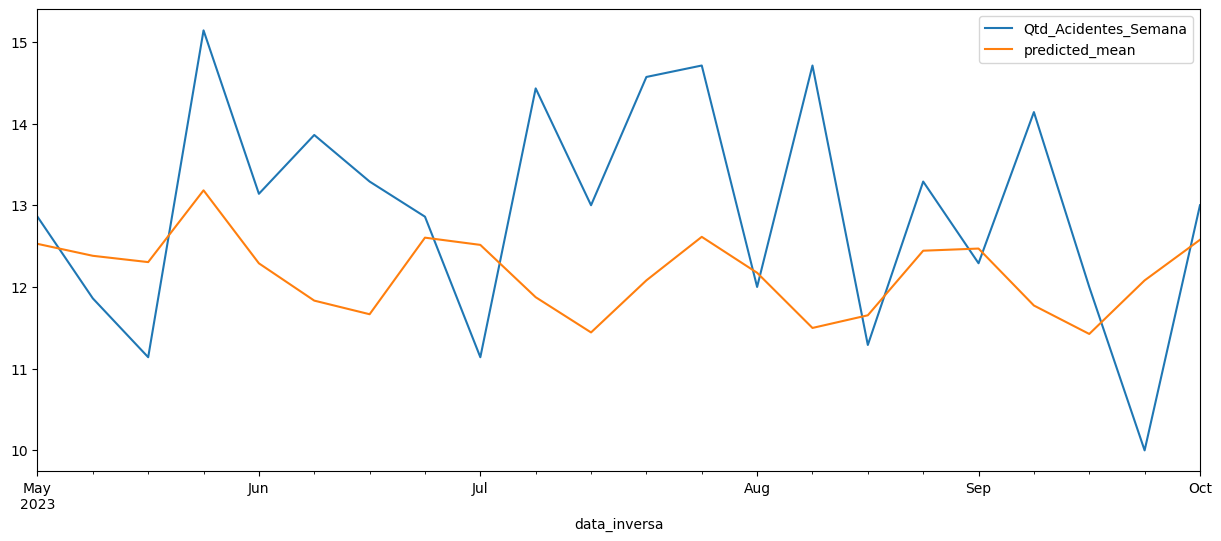

In [14]:
test['Qtd_Acidentes_Semana'].plot(legend=True)
pred.plot(legend=True, figsize=(15,6))
plt.show()

Visualmente através do gráfico, o modelo inicial foi capaz de evitar maiores flutuações do que os dados reais, embora não sendo capaz de capturar a variabilidade da série.  
Em complemento e de acordo ao gráfico, as métricas de erro MAE e MAPE foram baixas, com o modelo errando pouco. Já as métricas MSE e RMSE, que penalizam mais as predições mais distantes dos valores reais, foram um pouco mais elevadas, justificando a não capacidade de capturar a variabilidade.  

Outro ponto importante de se notar, é que foram previstos 22 amostras do conjunto de treino, e que quanto mais distante do fim do conjunto de treinamento, mais difícil foi para o modelo se aproximar do valor real, já que ele teve a tendência de seguir um padrão com baixa flutuação. Portanto, não é uma boa escolha, tentar prever muitas semanas a frente, pois haverá maior probabilidade de erro.

---
### 2.1.4 Forecasting

Afim de prever futuros valores da série temporal, isto é, valores das próximas semanas, será modelado novamente o ARIMA com todos os dados da série, utilizando a mesma ordem: (5,0,5).  

In [ ]:
model_arima = ARIMA(df_arima, order=(5,0,5))
modelfit = model_arima.fit()
# modelfit.summary()

É possível utilizar a própria função forecast() obtida no modelo ARIMA para prever os 5 próximos valores.

In [16]:
# Valores preditos sobre o conjunto
df_pred = pd.DataFrame(modelfit.predict())

# Valores previstos para o futuro da série
df_fc = pd.DataFrame(modelfit.forecast(5))

# Tomando o último valor predito e empilhando os 5 valores previstos
df_arima_fc = df_pred.iloc[(len(df_pred)-2):(len(df_pred))]
df_arima_fc = df_arima_fc[['predicted_mean']][-1:]
df_arima_fc = df_arima_fc.append(df_fc)

df_fc

,predicted_mean
2023-10-08,12.381885
2023-10-15,11.833434
2023-10-22,11.763568
2023-10-29,12.477755
2023-11-05,12.568400


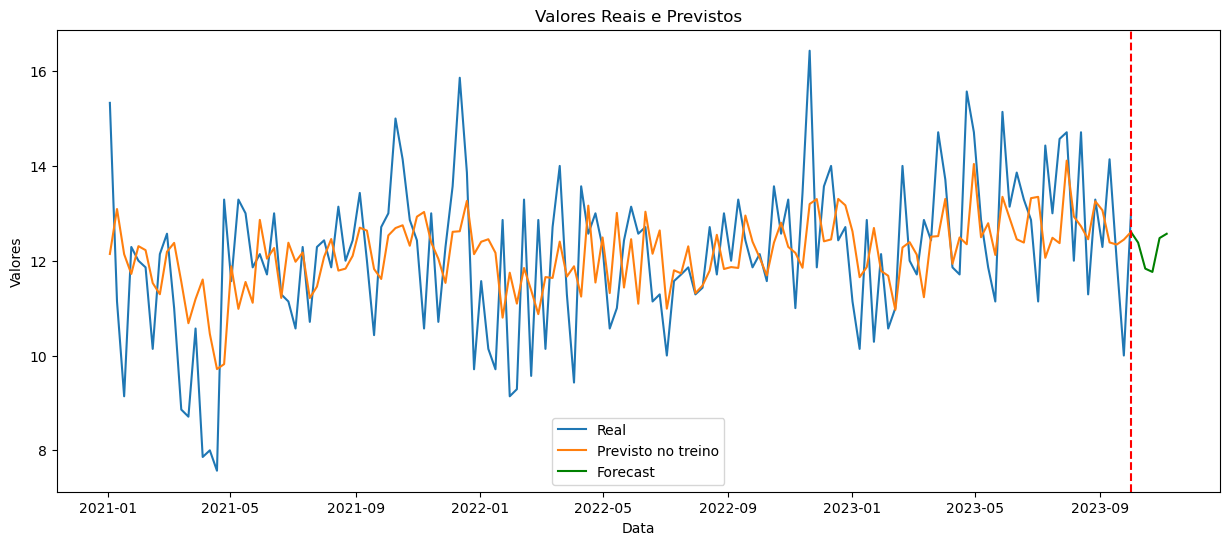

In [17]:
# Gráfico comparativo
plt.figure(figsize=(15, 6))
plt.plot(df_arima['Qtd_Acidentes_Semana'], label='Real')
plt.plot(df_pred['predicted_mean'], label='Previsto no treino')
plt.plot(df_arima_fc['predicted_mean'], label='Forecast', color='green')
plt.axvline(x=df_arima.index[len(df_arima)-1], color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Valores Reais e Previstos')
plt.legend()
plt.show()

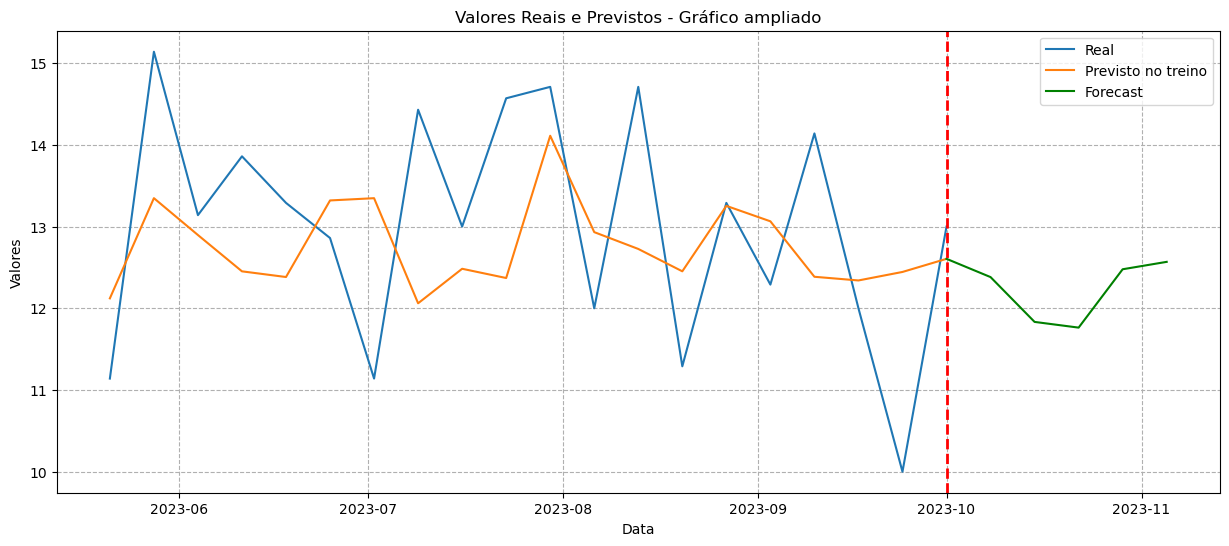

In [18]:
# Gráfico comparativo ampliado
plt.figure(figsize=(15, 6))
plt.plot(df_arima['Qtd_Acidentes_Semana'][-20:], label='Real')
plt.plot(df_pred['predicted_mean'][-20:], label='Previsto no treino')
plt.plot(df_arima_fc['predicted_mean'], label='Forecast', color='green')
plt.axvline(x=df_arima.index[len(df_arima)-1], color='red', linestyle='--',lw=2)
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Valores Reais e Previstos - Gráfico ampliado')
plt.grid(linestyle ='--')
plt.legend()
plt.show()

In [19]:
# Métricas
metricas(df_arima['Qtd_Acidentes_Semana'], df_pred)

MAE: 1.17 acidentes
MAPE: 10.04 % acidentes
MSE: 2.11 acidentes²
RMSE: 1.45 acidentes


Uma outra maneira de visualizar o ajuste do modelo é observando os **Resíduos** (Diferença entre os valores reais e previstos)

In [20]:
residual = pd.DataFrame(modelfit.resid)
residual.rename(columns={0: 'Residuo'}, inplace=True)
residual.describe()

,Residuo
count,144.000000
mean,-0.005082
std,1.457397
min,-3.743457
25%,-0.944465
50%,-0.035887
75%,0.994486
max,3.471588


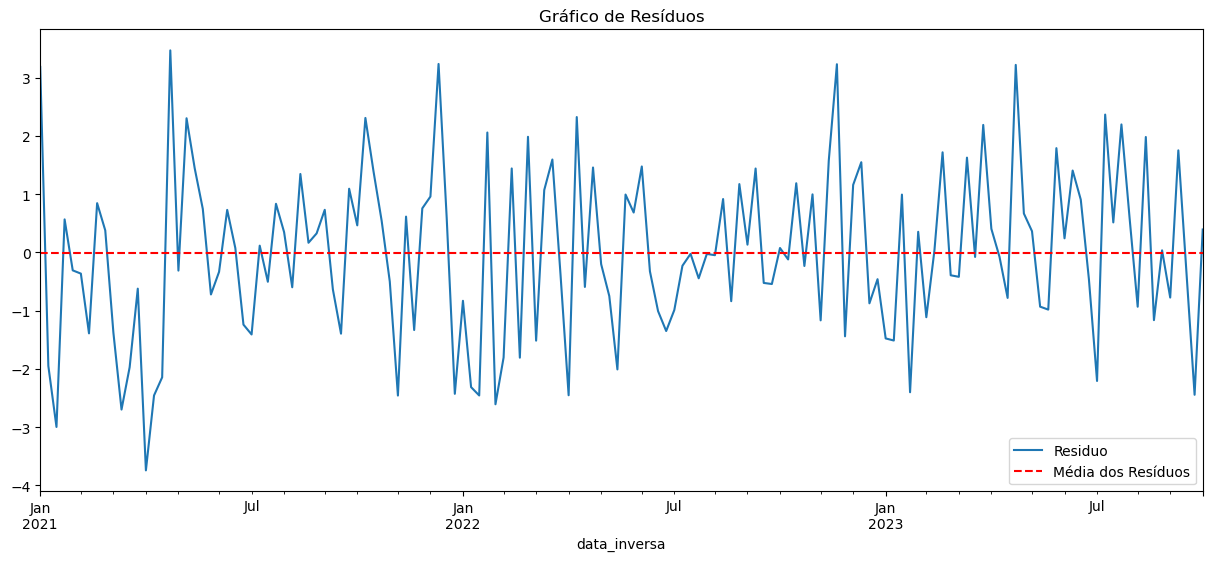

In [21]:
# Gráfico de resíduos
residual.plot(figsize=(15,6))
plt.title('Gráfico de Resíduos')
plt.axhline(y=np.mean(residual.values), color='r', linestyle='--', label='Média dos Resíduos')
plt.legend()
plt.show()

Analisando as métricas e os gráficos gerados de Valores Reais e Previstos, os resultados com o modelo ARIMA, utilizando todo os dados como conjunto de treinamento, foram bons, não havendo underfitting nem overfitting. Ademais, os valores futuros previstos seguem uma tendência de oscilação, tal como em toda a série, porém com flutuações mais suaves.

Já observando as estatísticas dos resíduos, tem-se uma média quase 0, confirmando que o modelo capturou a estacionaridade da série, e um desvio padrão de 1,45 acidentes. Fazendo um paralelo entre o gráfico de residuais e os gráficos anteriores, pode-se observar que os maiores residuais foram em datas em que houveram picos na série e que o modelo ARIMA não foi capaz de capturar/se ajustar.

Para se alcancar resultados possivelmente melhores, caberia treinar iterativamente o modelo ARIMA com diferentes ordens (talvez tomando mais lags) e realizar comparações entre estes modelos afim de inferir o melhor. Entretanto foge ao escopo deste projeto.

---
## 2.2. Regressão

Continuando com a modelagem para prever a quantidade de acidentes semanais para o estado de São Paulo, serão utilizados modelos de aprendizado supervisionado para realizar a regressão, como a Regressão Linear e XGBoost. Para tanto, é necessário criar novas features (atributos) que serão utilizadas como variáveis preditoras para o modelo, tal como as *lags features* de S semanas passadas, como S-1, S-2,..., S-n.  
Outras features estatísticas podem ser utilizados, como as *"Expanding window features"*. Uma boa feature deste grupo, seria usar a média de 's' semanas passadas, sem é claro, utilizar a própria semana para evitar vazamento de informação entre os conjuntos de treinamento e teste. Porém, para este momento serão utilizadas as *lags features* das últimas 5 semanas utilizando a função shift() da Pandas.

---
### 2.2.1. Preparação dos dados

In [22]:
df_reg = df_semanal.copy()

# Lags Features
df_reg['S-1'] = df_reg['Qtd_Acidentes_Semana'].shift(1)
df_reg['S-2'] = df_reg['Qtd_Acidentes_Semana'].shift(2)
df_reg['S-3'] = df_reg['Qtd_Acidentes_Semana'].shift(3)
df_reg['S-4'] = df_reg['Qtd_Acidentes_Semana'].shift(4)
df_reg['S-5'] = df_reg['Qtd_Acidentes_Semana'].shift(5)

# Remove linhas com valores vazios
df_reg.dropna(inplace=True)

# Divisão em conjuntos de treinamento e teste 85/15
train_size = int(len(df_reg) * 0.85) 
train, test = df_reg[:train_size], df_reg[train_size:]

# Separação variáveis preditoras e target
X_train, y_train = train.drop(columns=['Qtd_Acidentes_Semana']), train['Qtd_Acidentes_Semana']
X_test, y_test = test.drop(columns=['Qtd_Acidentes_Semana']), test['Qtd_Acidentes_Semana']

print("Quantidade de dados nos conjuntos de treinamento e no de teste")
print("Treinamento:", X_train.shape[0])
print("Teste:", X_test.shape[0])

Quantidade de dados nos conjuntos de treinamento e no de teste
Treinamento: 118
Teste: 21


### 2.2.2. Modelagem

Para um primeiro momento e de forma a comparar com os resultados obtidos no método ARIMA quando utilizado conjuntos de treinamento e teste, será usado o algoritmo LinearRegression() da biblioteca sklearn.

In [23]:
from sklearn.linear_model import LinearRegression

# Cria um modelo de regressão linear
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
pred_lin = model_lin.predict(X_test)

# Métricas
metricas(y_test, pred_lin)

MAE: 1.31 acidentes
MAPE: 10.08 % acidentes
MSE: 2.28 acidentes²
RMSE: 1.51 acidentes


In [24]:
# Predição
reg_pred = pd.DataFrame(y_test.copy())
reg_pred['preditos'] = pred_lin
reg_pred.head()

,Qtd_Acidentes_Semana,preditos
data_inversa,,
2023-05-14,11.86,12.775232
2023-05-21,11.14,12.157099
2023-05-28,15.14,12.202495
2023-06-04,13.14,13.075584
2023-06-11,13.86,12.620307


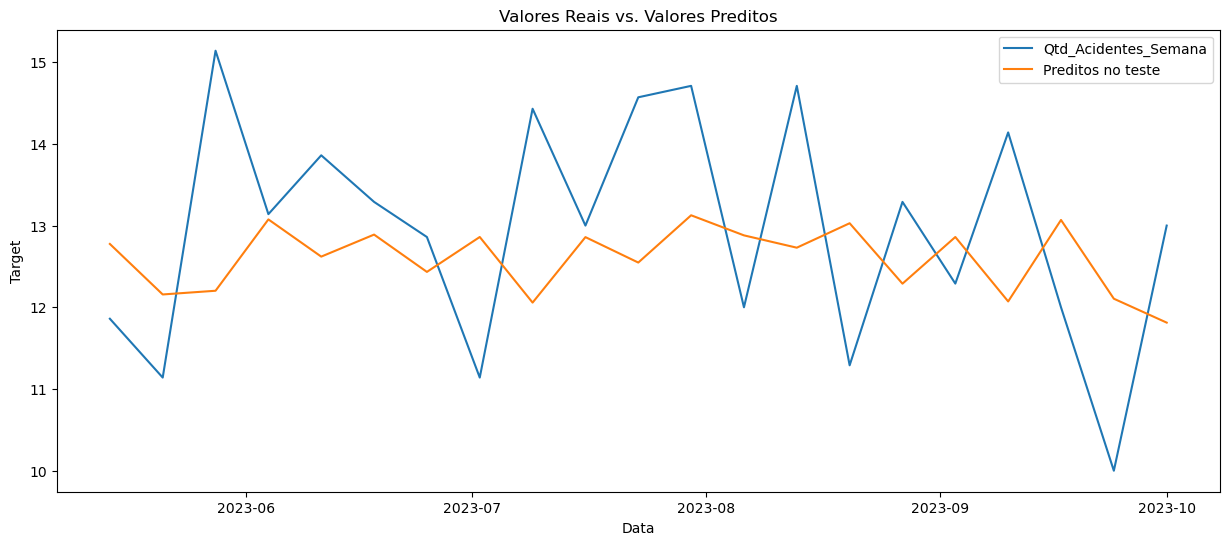

In [25]:
# Gráfico
plt.figure(figsize=(15, 6))
plt.plot(reg_pred, label=['Qtd_Acidentes_Semana', 'Preditos no teste'])
plt.title('Valores Reais vs. Valores Preditos')
plt.xlabel('Data')
plt.ylabel('Target')
plt.legend()
plt.show()

Comparando os valores de RMSE obtidos entre o método ARIMA (1.60 acidentes) e a regressão linear (1.51 acidentes), houve uma ligeira melhora na captura da variabilidade dos dados quando utilizado as lags features. Já os valores de MAE e MAPE fora praticamente os mesmos.  
Ademais, visualmente através do gráfico, novamente a predição parece manter uma tendência a ser mais centralizada a um valor médio, não se ajustando à variabilidade dos dados.

---
### 2.2.3. Forecasting

Assim como feito com o ARIMA, é possível treinar o modelo de regressão linear utilizando todos os dados da série temporal afim de prever o próximo ponto.

In [26]:
# Separação variável preditora e target
X, y = df_reg.drop(columns=['Qtd_Acidentes_Semana']), df_reg['Qtd_Acidentes_Semana']

print("Quantidade de dados nos conjuntos de treinamento e no de teste")
print("Treinamento:", X_train.shape[0])

# Cria um modelo de regressão linear
model_lin = LinearRegression()
model_lin.fit(X, y)
pred_lin = model_lin.predict(X)

# Métricas
metricas(y, pred_lin)

Quantidade de dados nos conjuntos de treinamento e no de teste
Treinamento: 118
MAE: 1.18 acidentes
MAPE: 10.1 % acidentes
MSE: 2.16 acidentes²
RMSE: 1.47 acidentes


Interessante notar que o RMSE não foi próximo de zero quando comparado os valores reais aos valores preditos pelo modelo. Sendo o nosso conjunto de treinamento toda a série, isso significa que treinar o modelo com toda a série usando lags features não implicou em overfitting, porém tampouco pode capturar a variabilidade da série. Ainda, comparado ao modelo ARIMA treinado com todos os dados, os valores de rmse foram similiares (1.45 e 1.47 acidentes).

Para prever os próximos valores da série, serão utilizados as features do último ponto da série de modo a prever o ponto imediatamente depois e, com esse valor predito, usá-lo para prever o ponto subsequente à este. E assim sucessivamente. Percebe-se que para tanto, é necessário que as features criadas sejam sempre com dados passados e independentes de alguma feature do ponto atual, tal como realizado com as lags features. Do contrário, não seria possível criar uma previsão de dados futuros já que não seria possível calcular as features.

In [27]:
# Dados sobre o último ponto da série
features_predicao = X.iloc[-1:]
ts = features_predicao.index[0]

# Número de semanas a serem previstas
num_sem = 5

# Lista para armazenar as previsões e datas
previsoes = []
list_ts = []

# Loop para prever as próximas semanas
for _ in range(num_sem):
    # Data da próxima semana
    ts += pd.Timedelta(days=7)
    list_ts.append(ts)
    
    # Fazendo e armazenando a previsão
    predicao = model_lin.predict(features_predicao)
    previsoes.append(predicao[0])
    
    # Atualizando as features para a próxima iteração
    features_predicao = np.roll(features_predicao, shift=1)
    features_predicao[0, 0] = predicao[0]

# DataFrame com as previsões
df_previsoes = pd.DataFrame({'preditos': previsoes}, index = list_ts)
df_previsoes

,preditos
2023-10-08,11.954001
2023-10-15,11.847875
2023-10-22,12.273797
2023-10-29,12.117768
2023-11-05,11.787962


In [28]:
# Preparação do gráfico
reg_pred = pd.DataFrame(y.copy())
reg_pred['preditos'] = pred_lin

# Tomando o último valor predito e empilhando os 5 valores previstos
df_reg_fc = reg_pred.iloc[-1:]
df_reg_fc = df_reg_fc.drop(columns=['Qtd_Acidentes_Semana']).append(df_previsoes)
df_reg_fc

,preditos
2023-10-01,11.954001
2023-10-08,11.954001
2023-10-15,11.847875
2023-10-22,12.273797
2023-10-29,12.117768
2023-11-05,11.787962


In [29]:
reg_pred

,Qtd_Acidentes_Semana,preditos
data_inversa,,
2021-02-07,11.86,12.503739
2021-02-14,10.14,11.924785
2021-02-21,12.14,11.161416
2021-02-28,12.57,11.909752
2021-03-07,11.00,12.110430
...,...,...
2023-09-03,12.29,12.865583
2023-09-10,14.14,12.238939
2023-09-17,12.00,13.103539


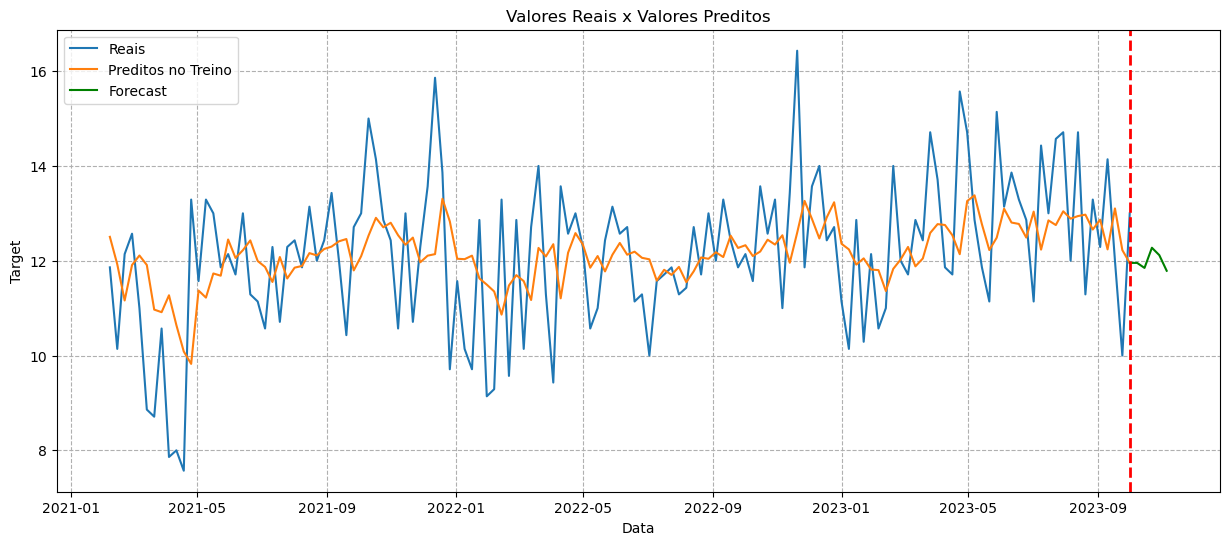

In [30]:
# Gráfico
plt.figure(figsize=(15, 6))
plt.plot(reg_pred, label=['Reais', 'Preditos no Treino'])
plt.plot(df_reg_fc, label='Forecast', color='green')
plt.axvline(x=reg_pred.index[len(reg_pred)-1], color='red', linestyle='--',lw=2)
plt.title('Valores Reais x Valores Preditos')
plt.xlabel('Data')
plt.ylabel('Target')
plt.grid(linestyle ='--')
plt.legend()
plt.show()

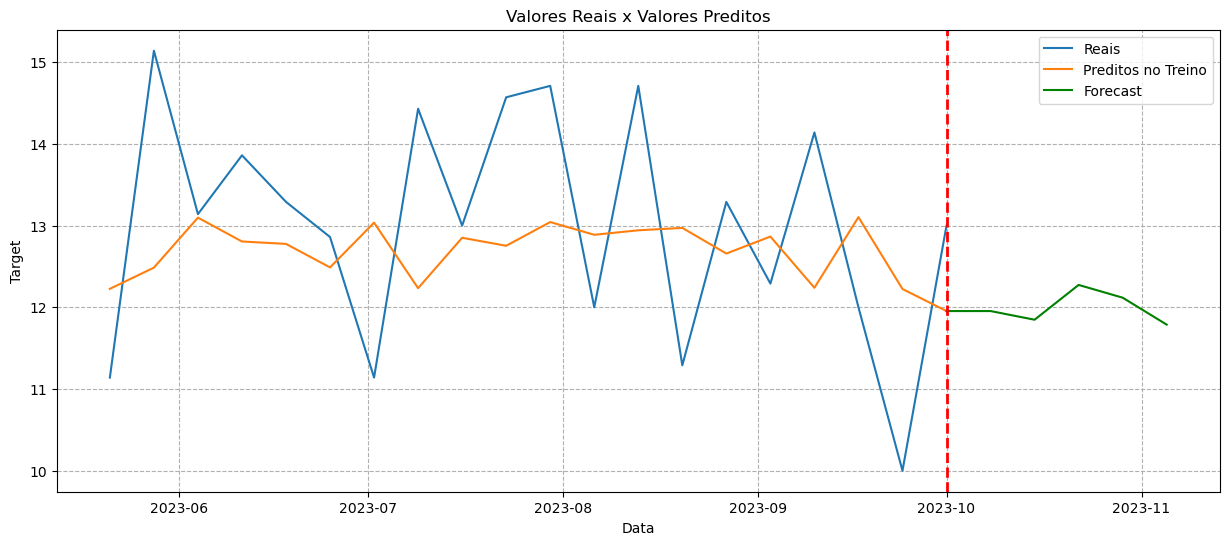

In [31]:
# Gráfico ampliado
plt.figure(figsize=(15, 6))
plt.plot(reg_pred[-20:], label=['Reais', 'Preditos no Treino'])
plt.plot(df_reg_fc[-20:], label='Forecast', color='green')
plt.axvline(x=reg_pred.index[len(reg_pred)-1], color='red', linestyle='--',lw=2)
plt.title('Valores Reais x Valores Preditos')
plt.xlabel('Data')
plt.ylabel('Target')
plt.grid(linestyle ='--')
plt.legend()
plt.show()

Percebe-se através de ambos os gráficos, que ao modelar a regressão linear os valores preditos sobre os valores reais da série temporal, tendem a manter menor variabilidade e se centralizando sob a série, isto é, mantendo-se na média. Já ao prever os próximos pontos da série temporal, os valores previstos futuros também foram tiveram menores flutuações.

---
## 2.3. Comparação

Podemos gerar um gráfico ampliado com os modelos gerados através do método ARIMA e da Regressão Linear quando treinados utilizando todos os dados da série temporal:

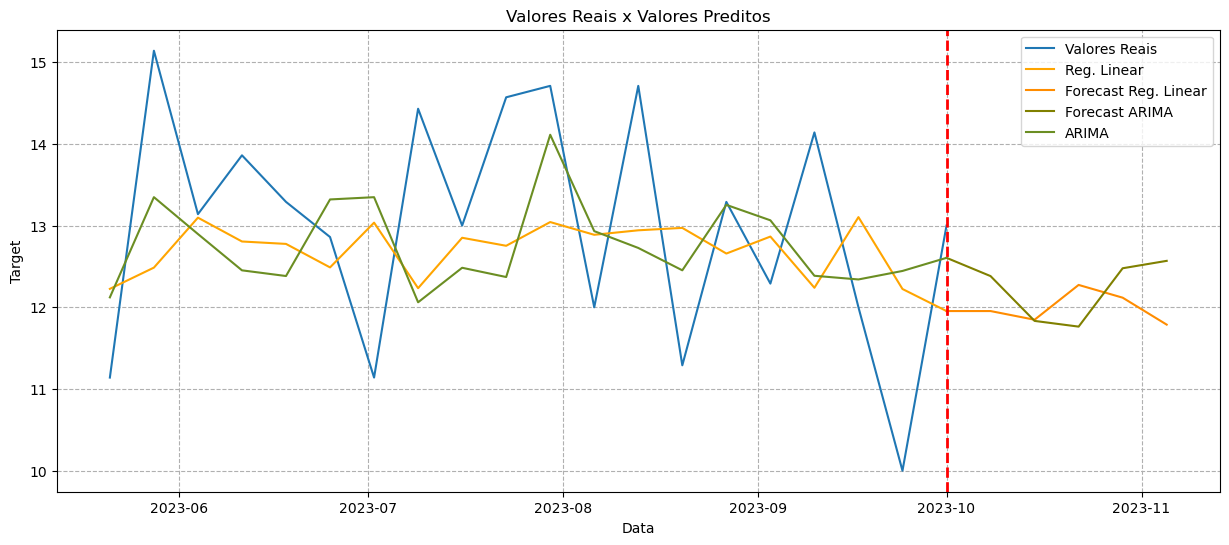

In [32]:
plt.figure(figsize=(15, 6))
# Reais
plt.plot(reg_pred['Qtd_Acidentes_Semana'][-20:], label='Valores Reais')
# Reg. Linear
plt.plot(reg_pred['preditos'][-20:], label='Reg. Linear', color='orange')
plt.plot(df_reg_fc[-20:], label='Forecast Reg. Linear', color='darkorange')
# Arima
plt.plot(df_arima_fc['predicted_mean'], label='Forecast ARIMA', color='olive')
plt.plot(df_pred['predicted_mean'][-20:], label='ARIMA', color='olivedrab')
# Settings
plt.axvline(x=reg_pred.index[len(reg_pred)-1], color='red', linestyle='--',lw=2)
plt.title('Valores Reais x Valores Preditos')
plt.xlabel('Data')
plt.ylabel('Target')
plt.grid(linestyle ='--')
plt.legend()
plt.show()

Neste gráfico comparativo fica mais evidente a tendência do modelo de regressão linear gerado, manter-se próximo a um valor médio enquanto que o modelo ARIMA explora mais a variablidade da série.

---
## 2.4. Modelagem para perspectiva diária

Embora a perspectiva diária sofra mais com flutuações de curto prazo, podemos tentar modelá-la, criando outras features como média móvel e desvio padrão, mês, dia do mês e o dia da semana.

Serão utilizados dois modelo de regressão: Novamente o modelo Linear e o XGBoost, que é um modelo de árvore de decisão que, além de realizar a regressão, também pode atribuir maiores pesos à atributos mais importantes.

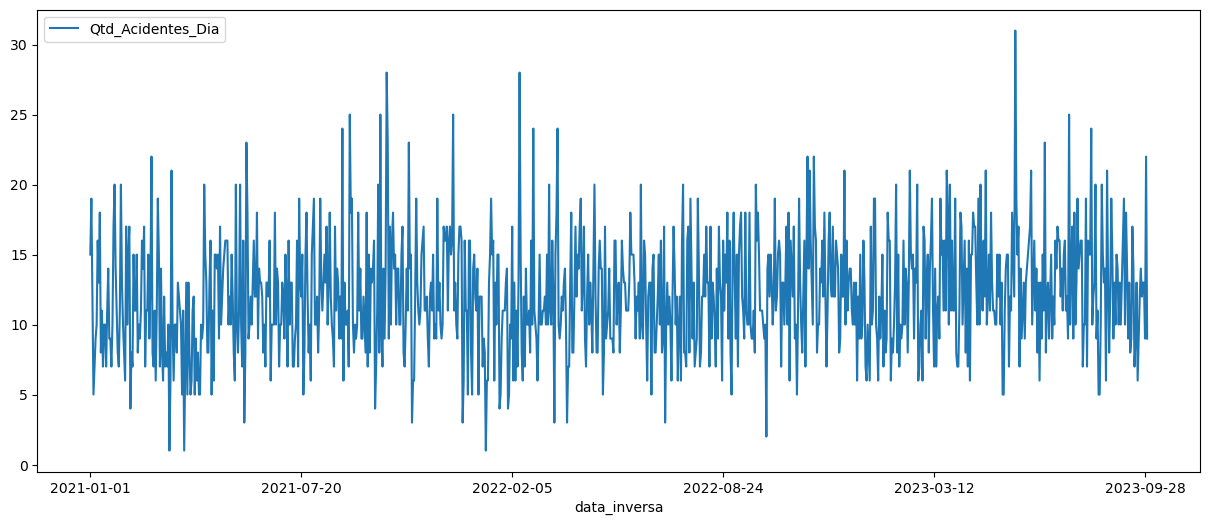

In [33]:
# Gráfico acidentes por dia em São Paulo
df_dia.plot(figsize=(15, 6))
plt.show()

### 2.4.1. Preparação dos dados

In [34]:
df_reg_dia = df_dia.copy()

# Features de dia da semana, mês e dia do mês
df_reg_dia.index = pd.to_datetime(df_reg_dia.index)
df_reg_dia['dia_da_semana'] = df_reg_dia.index.dayofweek
df_reg_dia['dia_do_mes'] = df_reg_dia.index.day
df_reg_dia['mes'] = df_reg_dia.index.month
df_reg_dia.head()

,Qtd_Acidentes_Dia,dia_da_semana,dia_do_mes,mes
data_inversa,,,,
2021-01-01,15,4,1,1
2021-01-02,19,5,2,1
2021-01-03,12,6,3,1
2021-01-04,5,0,4,1
2021-01-05,7,1,5,1


In [35]:
# Lag Features
df_reg_dia['S-1'] = df_reg_dia['Qtd_Acidentes_Dia'].shift(1)
df_reg_dia['S-2'] = df_reg_dia['Qtd_Acidentes_Dia'].shift(2)
df_reg_dia['S-3'] = df_reg_dia['Qtd_Acidentes_Dia'].shift(3)
df_reg_dia['S-4'] = df_reg_dia['Qtd_Acidentes_Dia'].shift(4)
df_reg_dia['S-5'] = df_reg_dia['Qtd_Acidentes_Dia'].shift(5)

# Divisão em conjuntos de treinamento e teste 90/10
train_size = int(len(df_reg_dia) * 0.90)
train, test = df_reg_dia[:train_size], df_reg_dia[train_size:]

# Features de média móvel e desvio padrão de 3 dias
train['media_movel_3'] = train['Qtd_Acidentes_Dia'].shift(1).rolling(window=3).mean()
test['media_movel_3'] = test['Qtd_Acidentes_Dia'].shift(1).rolling(window=3).mean()
train['dev_pad_3'] = train['Qtd_Acidentes_Dia'].shift(1).rolling(window=3).std()
test['dev_pad_3'] = test['Qtd_Acidentes_Dia'].shift(1).rolling(window=3).std()

# Remove linhas vazias
train.dropna(inplace=True)
test.dropna(inplace=True)

# Separação variáveis preditoras e target
X_train, y_train = train.drop(columns=['Qtd_Acidentes_Dia']), train['Qtd_Acidentes_Dia']
X_test, y_test = test.drop(columns=['Qtd_Acidentes_Dia']), test['Qtd_Acidentes_Dia']

print("Quantidade de dados nos conjuntos de treinamento e no de teste")
print("Treinamento:", X_train.shape[0])
print("Teste:", X_test.shape[0])

Quantidade de dados nos conjuntos de treinamento e no de teste
Treinamento: 897
Teste: 98


Para evitar vazamento de informação entre os conjuntos de treinamento e de teste, é importante primeiro separar os conjuntos e depois calcular as features, como a média móvel e desvio padrão. Outro ponto é que essas features foram criadas usando dados anteriores à linha do cálculo, para que seja possível prever dados futuros, afinal, não será possível prever dados futuros se depender do valor a ser previsto no cálculo.

In [36]:
train.head()

,Qtd_Acidentes_Dia,dia_da_semana,dia_do_mes,mes,S-1,S-2,S-3,S-4,S-5,media_movel_3,dev_pad_3
data_inversa,,,,,,,,,,,
2021-01-06,9,2,6,1,7.0,5.0,12.0,19.0,15.0,8.000000,3.605551
2021-01-07,10,3,7,1,9.0,7.0,5.0,12.0,19.0,7.000000,2.000000
2021-01-08,16,4,8,1,10.0,9.0,7.0,5.0,12.0,8.666667,1.527525
2021-01-09,13,5,9,1,16.0,10.0,9.0,7.0,5.0,11.666667,3.785939
2021-01-10,18,6,10,1,13.0,16.0,10.0,9.0,7.0,13.000000,3.000000


### 2.4.2. Modelagem
---
### 2.4.2.1. Regressão Linear

In [37]:
# Cria um modelo de regressão linear
model_lin_dia = LinearRegression()
model_lin_dia.fit(X_train, y_train)
pred_lin_dia = model_lin_dia.predict(X_test)

### 2.4.2.2. XGBoost

Como parâmetros do XGBRegressor, será atribuido *"n_estimators=1000"* representando o número total de árvores a serem criadas durante o treinamento. Como critério de parada do modelo, se não houver melhoria da métrica de validação do modelo (neste caso rmse) após 25 rodadas (*"early_stopping_rounds=25"*), o treinamento será interrompido e portanto não haverá necessidade de criar 1000 árvores. O rmse será calculado sobre o conjunto de teste (eval_set).

In [38]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=25)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

pred_xgb = model_xgb.predict(X_test)

[0]	validation_0-rmse:3.81813	validation_1-rmse:4.18538
[1]	validation_0-rmse:3.57305	validation_1-rmse:4.11946
[2]	validation_0-rmse:3.37063	validation_1-rmse:4.00529
[3]	validation_0-rmse:3.22619	validation_1-rmse:3.99262
[4]	validation_0-rmse:3.08937	validation_1-rmse:3.97008
[5]	validation_0-rmse:2.90107	validation_1-rmse:3.96361
[6]	validation_0-rmse:2.79025	validation_1-rmse:3.99307
[7]	validation_0-rmse:2.67831	validation_1-rmse:4.02919
[8]	validation_0-rmse:2.57843	validation_1-rmse:4.02258
[9]	validation_0-rmse:2.54604	validation_1-rmse:4.04630
[10]	validation_0-rmse:2.42526	validation_1-rmse:4.09348
[11]	validation_0-rmse:2.38556	validation_1-rmse:4.10541
[12]	validation_0-rmse:2.28746	validation_1-rmse:4.11369
[13]	validation_0-rmse:2.21545	validation_1-rmse:4.11221
[14]	validation_0-rmse:2.11981	validation_1-rmse:4.15258
[15]	validation_0-rmse:2.02256	validation_1-rmse:4.12895
[16]	validation_0-rmse:2.01080	validation_1-rmse:4.14968
[17]	validation_0-rmse:1.94232	validation

Através dos resultados obtidos, percebe-se que após a rodada [5] a métrica rmse sobre o conjunto de teste (coluna à direita) torna a subir, logo não havendo mais melhora na validação. Por outro lado, percebe-se que vai ocorrendo overfitting sobre o conjunto de treinamento, com o rmse tendendo à zero.  

Uma característica interessante obtida a partir do XGBoost é que pode-se obter a importância que cada feature preditora representou na modelagem, utilizando a função ***feature_importances_***:

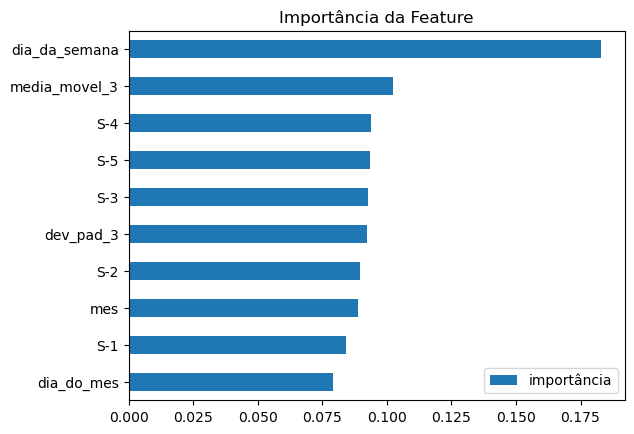

In [39]:
fi = pd.DataFrame(data=model_xgb.feature_importances_,
             index=model_xgb.feature_names_in_,
             columns=['importância'])
fi.sort_values('importância').plot(kind='barh', title='Importância da Feature')
plt.show()

Através do gráfico de importância da Feature, vemos que a feature criada dia da semana foi a que mais contribuiu para o modelo, isto é, a feature mais importante seguida da média móvel de 3 dias. Percebe-se que é uma feature importante e que não era possível ser considerada quando a modelagem abordou a perspectiva semanal.  
Analisando o resultado, é plausível que possa haver causalidade entre o dia da semana e a quantidade de acidente, dado que, por exemplo, possa haver mais veículos em movimento nas rodovias durante os finais de semana. Porém, caberia uma análise mais aprofundado e com outras bases de dados, já que esta somente contém dados sobre acidentes ocorridos e não sobre todos os veículos em trânsito.

In [40]:
# Preparação gráfico
pred_dia = pd.DataFrame(y_test.copy())
pred_dia['preditos_reg_lin'] = pred_lin_dia
pred_dia['preditos_xgb'] = pred_xgb
pred_dia.head()

,Qtd_Acidentes_Dia,preditos_reg_lin,preditos_xgb
data_inversa,,,
2023-06-25,23,13.916250,13.450846
2023-06-26,8,10.949756,11.709883
2023-06-27,12,10.718310,11.277833
2023-06-28,13,11.742371,11.358166
2023-06-29,9,11.735173,9.382511


Métricas Regressão Linear:

MAE: 3.2 acidentes
MAPE: 26.99 % acidentes
MSE: 16.81 acidentes²
RMSE: 4.1 acidentes

Métricas XGBoost:

MAE: 3.14 acidentes
MAPE: 25.74 % acidentes
MSE: 15.71 acidentes²
RMSE: 3.96 acidentes


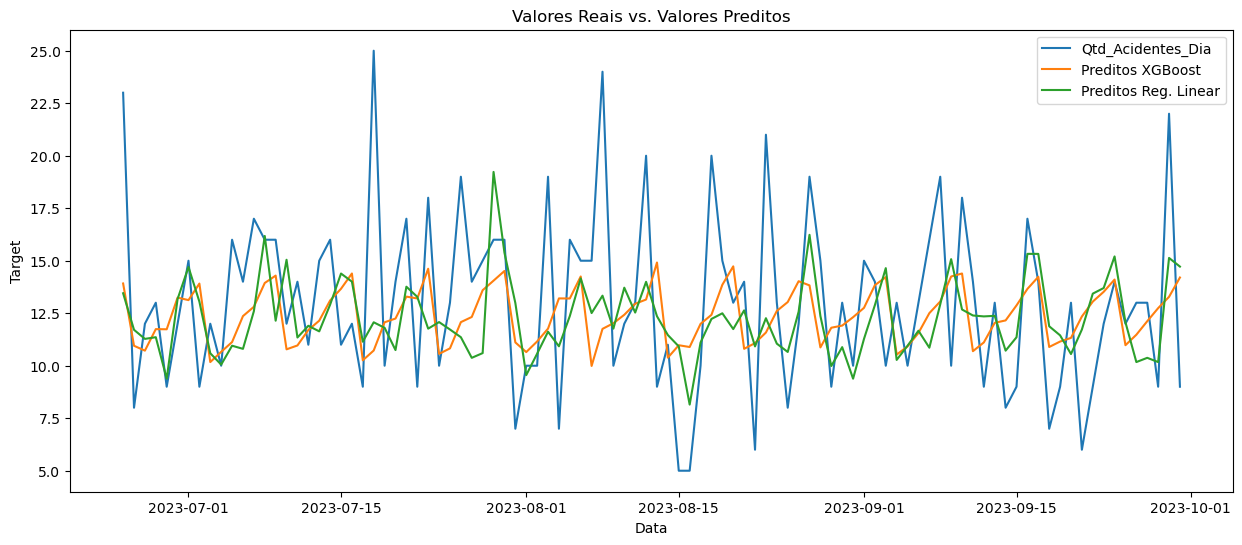

In [41]:
# Métricas
print("Métricas Regressão Linear:\n")
metricas(y_test, pred_lin_dia)
print("\nMétricas XGBoost:\n")
metricas(y_test, pred_xgb)

# Plotagem
plt.figure(figsize=(15, 6))
plt.plot(pred_dia, label=['Qtd_Acidentes_Dia','Preditos XGBoost', 'Preditos Reg. Linear'])
plt.title('Valores Reais vs. Valores Preditos')
plt.xlabel('Data')
plt.ylabel('Target')
plt.legend()
plt.show()

Evidentemente que, ao abordar uma perspectiva diária, há maior suscetibilidade à flutuações de curto prazo, o que por consequência, torna mais difícil de obter um modelo que captura esta maior variabilidade. Os resultados obtidos pela métrica de validação rmse, 4.1 acidentes para o modelo de regressão linear e 3,96 acidentes para o XGBoost, corroboram à isso. Também em consequência à maior variação, o erro percentual obtido pela métrica MAPE, em ambos os casos, indica que os resultados não foram acurados.  
Outra observação a ser feita é que, através do gráfico, percebe-se que o modelo obtido com o XGBoost tende a criar uma sazonalidade mais evidente nas predições.

---

# 3. Conclusão

A estratégia de adotar uma perspectiva semanal, usando a média dos acidentes dos últimos 7 dias, demonstrou-se eficaz para suavizar variações diárias e destacar tendências de médio prazo na série temporal.

Ambos os modelos usados, ARIMA e Regressão Linear, apresentaram resultados semelhantes em termos das métricas de erro utilizadas: MAE, MAPE, MSE e RMSE. Essa semelhança sugere que ambos são capazes de realizar previsões razoáveis para a quantidade de acidentes no estado de São Paulo, e que não houve um ganho justificável para utilizar o modelo estatístico ou o modelo de aprendizado supervisionado.

Posteriormente, uma abordagem mais granular foi explorada com Regressão Linear e modelo XGBoost, focado na previsão diária de acidentes. Embora tenha apresentado métricas com valores mais elevados, o que era esperado dado o aumento na granularidade, essa abordagem forneceu uma visão mais detalhada das flutuações diárias e sobre como olhar para essa perspectiva possibilita utilizar-se de outras features, como dia da semana, que se mostrou muito importante para a árvore de decisão gerado pelo modelo XGBoost.

Evidentemente, há oportunidades para aprimoramentos, como a exploração de mais features, otimização de hiperparâmetros dos modelos e a continuidade da análise explorando mais dados do próprio dataset utilizado como fonte de dados, como estado, cidade, condição meteorológica, entre outros. A incorporação de variáveis adicionais pode enriquecer a compreensão dos padrões temporais e permitir que o modelo capture nuances mais complexas, contribuindo assim para previsões mais precisas e contextualmente relevantes. Esse processo iterativo de refinamento é essencial para desenvolver um modelo que seja não apenas preciso, mas também adaptável a diferentes condições e cenários.

---

# 4. Referências

Machine Learning na previsão de Séries Temporais: https://www.bi4all.pt/noticias/blog/machine-learning-na-previsao-de-series-temporais/  
Séries temporais com Machine Learning: https://medium.com/data-hackers/séries-temporais-com-machine-learning-parte-4-6beb3efb2e99  
Princípios basícos para criar previsões de Séries Temporais: https://medium.com/ensina-ai/princípios-básicos-para-criar-previsões-de-séries-temporais-e58c451a25b   
Identifying the numbers of AR or MA terms in an ARIMA model: https://people.duke.edu/~rnau/411arim3.htm  
Introduction to feature engineering for time series forecasting: https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0


**Documentações:**
- Pandas: https://pandas.pydata.org/docs/user_guide/index.html#user-guide
- Pandas resample: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
- Numpy: https://numpy.org/doc/stable/user/index.html#user
- MatplotLib: https://matplotlib.org/stable/users/index
- Warnings: https://docs.python.org/3/library/warnings.html
- os: https://docs.python.org/3/library/os.html
- adfuller: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
- ACF: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html#statsmodels.graphics.tsaplots.plot_acf
- PACF: https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html#statsmodels.graphics.tsaplots.plot_pacf
- ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
- Sklearn - Métricas: https://scikit-learn.org/stable/modules/model_evaluation.html
- Regressão Linear: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- XGBoost Regressor: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor

**Material de apoio:**

Time Series Forecasting: https://youtube.com/playlist?list=PLqYFiz7NM_SMC4ZgXplbreXlRY4Jf4zBP&si=H8K1K07hlbR9ciL5  
Time Series Forecasting with XGBoost: https://youtu.be/vV12dGe_Fho?si=Wi4ElU6FPqflFQpd  
Prevendo Vendas com ARIMA: https://youtu.be/v7rZpT8NCbk?si=j2ozPMj25Goe-CAX  
How to build ARIMA models in Python for time series forecasting: https://youtu.be/-aCF0_wfVwY?si=9Emrcz9N2b9YhFR3  
ARIMA in python. Best way to Identify p d q. Time Serie Forecasting: https://youtu.be/_qv_7lEuiZg?si=Fjyt66-dvjsHqiUi  